# EL MAHDI EL ALJ GH1033521
# Big Data Analytics M508
# Final Individual assignment
# Sentiment Analysis for Apple IPhone Customer Reviews


# Business Problem
Iphone Smartphone is the most popular phone in the world and Because of high number of competitors in the international market, customers feedback are very important for the compagny to understanding the customers satisfaction, and performance of the product.

By Analysing large volume of customer reviews using sentiment analysis, we can classify the feedback in 3 section: positive, negative or neutral.

For example analyzing negative feedback can help the compagny to define the arrea of improvement.
By analyzing positive feedback we can identify the preference of the customers.

Goals of this analysis is to improve customer satisfaction score, understanding customers needs that can lead to increase benefit of the compagny.


# Introduction
customer feedback provide us the performace of the product and using sentiment analysis in machine learning, will atomates the process of classifing customer feedback, this project will demonstrate how to use sentiment analysis, to classify iphone customer review in positive, negative or neutral, using Python.

# Import the necessary librairies

In [7]:
!pip install datasets

In [8]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
import numpy as np
import seaborn as sns

from datasets import Dataset
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


import transformers
from datasets import load_dataset

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Loading our dataset using the full dataset

In [9]:
data = pd.read_csv('/content/iphone.csv')

# Explore data

In [10]:
print(data.head())
print(data.tail())

  productAsin country        date  isVerified  ratingScore  \
0  B09G9BL5CP   India  11-08-2024        True            4   
1  B09G9BL5CP   India  16-08-2024        True            5   
2  B09G9BL5CP   India  14-05-2024        True            4   
3  B09G9BL5CP   India  24-06-2024        True            5   
4  B09G9BL5CP   India  18-05-2024        True            5   

               reviewTitle                                  reviewDescription  \
0               No charger  Every thing is good about iPhones, there's not...   
1          iPhone 13 256GB  It look so fabulous, I am android user switche...   
2  Flip camera option nill  I tried to flip camera while recording but no ...   
3                  Product                                       100% genuine   
4             Good product         Happy to get the iPhone 13 in Amazon offer   

                                           reviewUrl  \
0  https://www.amazon.in/gp/customer-reviews/R345...   
1  https://www.amazon.in/gp/

# Choosing the necessary columns


In [11]:
data = data[['reviewDescription', 'ratingScore']]

# Checking for missing values

In [12]:
data.dropna(subset=['reviewDescription'], inplace=True)
print(data.head())

                                   reviewDescription  ratingScore
0  Every thing is good about iPhones, there's not...            4
1  It look so fabulous, I am android user switche...            5
2  I tried to flip camera while recording but no ...            4
3                                       100% genuine            5
4         Happy to get the iPhone 13 in Amazon offer            5


# Sentiment Labels

In [13]:
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

data['sentiment'] = data['ratingScore'].apply(map_rating_to_sentiment)
data = data[['reviewDescription', 'sentiment']]
print(data.head())

                                   reviewDescription sentiment
0  Every thing is good about iPhones, there's not...  positive
1  It look so fabulous, I am android user switche...  positive
2  I tried to flip camera while recording but no ...  positive
3                                       100% genuine  positive
4         Happy to get the iPhone 13 in Amazon offer  positive


# Data Visualization

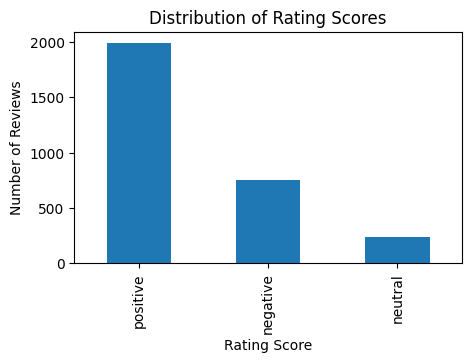

In [14]:
rating_counts = data['sentiment'].value_counts()
plt.figure(figsize=(5, 3))
rating_counts.plot(kind='bar')
plt.title('Distribution of Rating Scores')
plt.xlabel('Rating Score')
plt.ylabel('Number of Reviews')
plt.show()

# Distribution of Rating scores using pie chart

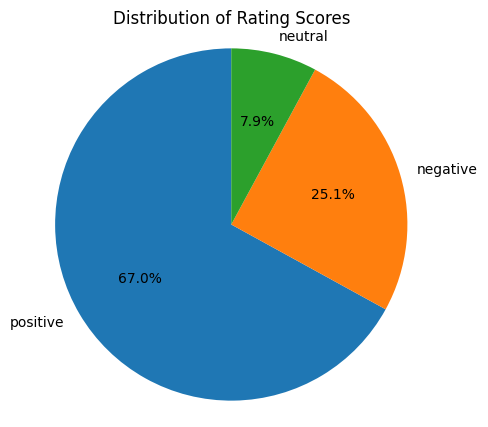

In [15]:
plt.figure(figsize=(5, 5))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Rating Scores')
plt.axis('equal')
plt.show()

# Preprocessing-text
Convert to lower case, remove non alphabetic characters, Tokenization,remove stopwords, lemmatization and join tokens.

In [16]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)
data['processed_text'] = data['reviewDescription'].apply(preprocess_text)
print(data[['reviewDescription', 'processed_text']].head())

                                   reviewDescription  \
0  Every thing is good about iPhones, there's not...   
1  It look so fabulous, I am android user switche...   
2  I tried to flip camera while recording but no ...   
3                                       100% genuine   
4         Happy to get the iPhone 13 in Amazon offer   

                                      processed_text  
0  every thing good iphones there nothing compare...  
1  look fabulous android user switched apple perf...  
2  tried flip camera recording facility added pau...  
3                                            genuine  
4                      happy get iphone amazon offer  


# TF-IDF vectorizer, transforms the processed text into a feature matrix

In [17]:
tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(data['processed_text']).toarray()
print("Feature shape:", X.shape)

Feature shape: (2976, 500)


# Balancing dataset

In [18]:
le = LabelEncoder()
y = le.fit_transform(data['sentiment'])

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Resampled feature shape:", X_resampled.shape)
print("Resampled target shape:", y_resampled.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Resampled feature shape: (5982, 500)
Resampled target shape: (5982,)


# Split the data into training and testing sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# StandardScaler

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# MODLING AND TRAINING

We will start by train and evaluate with basic models like LogisticRegression

## LogisticRegression Model

In [41]:
model = LogisticRegression()

model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print("Model accuracy:", accuracy)

Model accuracy1: 0.8446115288220551


we got great accurcy on traditional model due to our data cleaning step

## RandomForestClassifier
We train and test the model using RandomForestClassifier, Traditional Method


In [22]:
model = RandomForestClassifier()

model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print("Model accuracy:", accuracy)

Model accuracy: 0.8922305764411027


# Logistic Regression confusion matrix



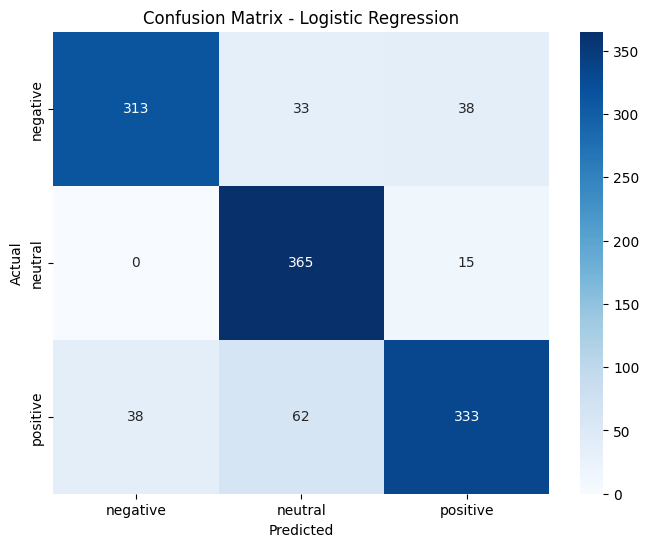

In [33]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

y_pred_logreg = logreg_model.predict(X_test)
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Random Forest model confusion matrix

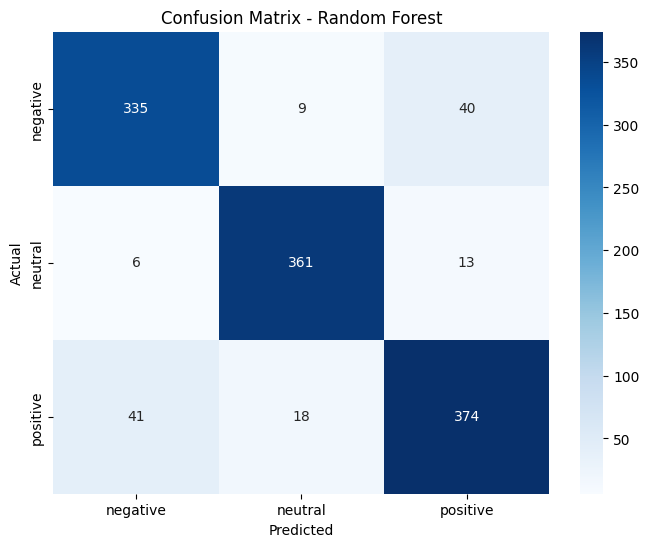

In [34]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# DistilRoBERTa Model: Advanced Model


In [24]:
model_name = "distilroberta-base"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

pd_train, pd_test = train_test_split(data, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
pd_train['encoded_labels'] = label_encoder.fit_transform(pd_train['sentiment'])
pd_test['encoded_labels'] = label_encoder.transform(pd_test['sentiment'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

# Preprocessing the Text

In [25]:
def preprocess_function(examples):
    return tokenizer(examples["reviewDescription"], truncation=True, padding="max_length", max_length=512)

train_dataset = Dataset.from_pandas(pd_train)
test_dataset = Dataset.from_pandas(pd_test)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

train_dataset = train_dataset.rename_column("encoded_labels", "labels")
test_dataset = test_dataset.rename_column("encoded_labels", "labels")

Map:   0%|          | 0/2380 [00:00<?, ? examples/s]

Map:   0%|          | 0/596 [00:00<?, ? examples/s]

# Model Initialization

In [26]:
data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer)

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(pd_train['sentiment'].unique())
)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Model setup and Arguments

In [27]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [28]:
training_args = transformers.TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    learning_rate=0.00002,
    num_train_epochs=1.5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    load_best_model_at_end=True,
    fp16=True,
    gradient_accumulation_steps=2,
    report_to="none",
)

trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-28-54c31a80e2ab>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = transformers.Trainer(


# Train the model

In [29]:
trainer.train()

Step,Training Loss,Validation Loss
10,0.948000,0.818665
20,0.875900,0.738421
30,0.766400,0.654232
40,0.672000,0.530356
50,0.561300,0.448874
60,0.506700,0.420812
70,0.475200,0.405596
80,0.433900,0.404239
90,0.469900,0.401362
100,0.443400,0.387154


Could not locate the best model at ./results/checkpoint-110/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=111, training_loss=0.5991416578894263, metrics={'train_runtime': 78.1314, 'train_samples_per_second': 45.692, 'train_steps_per_second': 1.421, 'total_flos': 467883195936768.0, 'train_loss': 0.5991416578894263, 'epoch': 1.483221476510067})

# Evaluate the model

In [30]:
trainer.evaluate()

{'eval_loss': 0.3830178678035736,
 'eval_runtime': 2.6319,
 'eval_samples_per_second': 226.456,
 'eval_steps_per_second': 14.438,
 'epoch': 1.483221476510067}

# DistilRoBERTa confusion matrix

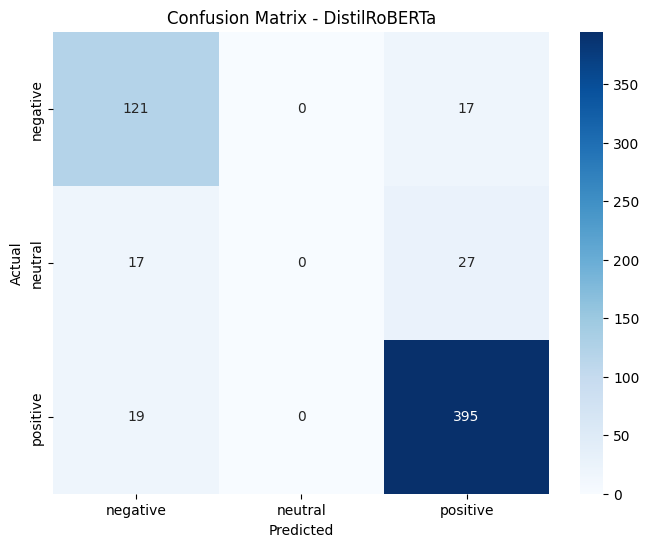

              precision    recall  f1-score   support

    negative       0.77      0.88      0.82       138
     neutral       0.00      0.00      0.00        44
    positive       0.90      0.95      0.93       414

    accuracy                           0.87       596
   macro avg       0.56      0.61      0.58       596
weighted avg       0.80      0.87      0.83       596



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

cm_distilroberta = confusion_matrix(test_dataset["labels"], predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_distilroberta, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - DistilRoBERTa')
plt.show()
print(classification_report(test_dataset["labels"], predicted_labels, target_names=label_encoder.classes_))

## Our best accuracy for DistilRoBERTa is 0.87 , unexpectedly lower than traditional models this may because we need to run bigger advanced model like bert but computing power does not support

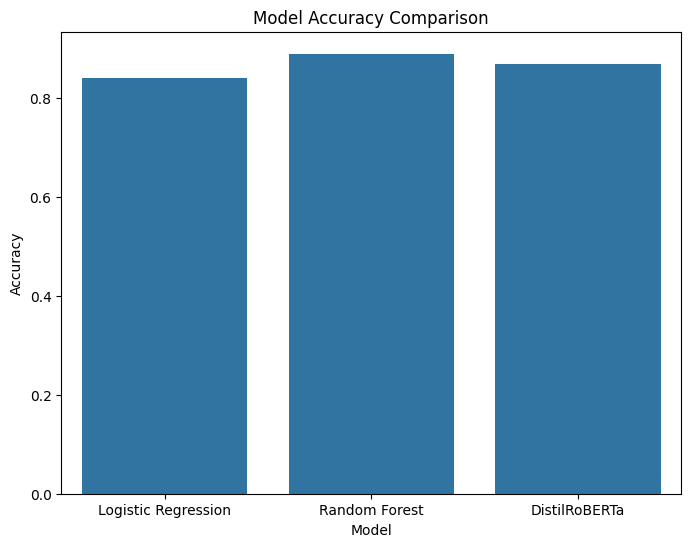

In [45]:
model_results = {
    "Logistic Regression": 0.84,
    "Random Forest": 0.89,
    "DistilRoBERTa": 0.87
}
results_df = pd.DataFrame.from_dict(model_results, orient="index", columns=["Accuracy"])

plt.figure(figsize=(8, 6))
sns.barplot(x=results_df.index, y="Accuracy", data=results_df)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

# Conclusion:
In this project we have applied successfully NLP pipline of sentiment analysis to classify customer reviews for Apple Iphone and this NLP pipeline contains the traditional method and the advanced like DistilRoBERTa , Random Forest and Logistic Regression has shown the best accuracy with differing scores in confusion matrix , in future work we can make more data cleaning and hypertuning and try bigger model like bert to get higher accuracy.

# Reference: https://www.kaggle.com/datasets/mrmars1010/iphone-customer-reviews-nlp/data